In [77]:
# Import necessary library
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from glove import Corpus, Glove
from keras.layers import SimpleRNN, Embedding, Dense, LSTM, Dropout, BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math
from keras.callbacks import ModelCheckpoint


### Loading data

In [79]:
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'./{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [80]:
train_df = load_data("train")
valid_df = load_data("valid")
test_df = load_data("test")

select [text, stars] columns from the train split
Success
select [text, stars] columns from the valid split
Success
select [text, stars] columns from the test split
Failed loading specified columns... Returning all columns from the test split


### Observation of the Dataset (Training Dataset)

In [81]:
train_df.drop([7376, 12207, 17890], axis=0, inplace=True)
train_df = train_df.reset_index(drop=True)

In [5]:
print(f"new shape of train_df: {train_df.shape}")
print(train_df.head())

new shape of train_df: (17997, 2)
                                                text  stars
0  Best Sunday buffet in the two cities of Charlo...      5
1  My friends and I decided to check out this pla...      4
2  This is definitely New York Chinese food! The ...      5
3  Beaucoup moins de choix que son voisin d'en fa...      3
4  Location is nice, but it is the typical blah H...      2


In [6]:
class5_count, class4_count, class1_count, class3_count, class2_count = train_df["stars"].value_counts()
print(class1_count)
print(class2_count)
print(class3_count)
print(class4_count)
print(class5_count)

2658
1426
1968
4008
7937


In [7]:
class1 = train_df[train_df["stars"]==1]
class2 = train_df[train_df["stars"]==2]
class3 = train_df[train_df["stars"]==3]
class4 = train_df[train_df["stars"]==4]
class5 = train_df[train_df["stars"]==5]

In [8]:
class1_over = class1.sample(500, replace=True)
class2_over = class2.sample(1000, replace=True)
class3_over = class3.sample(1000, replace=True)

In [9]:
new1 = pd.concat([class1_over, class1], axis=0)
new2 = pd.concat([class2_over, class2], axis=0)
new3 = pd.concat([class3_over, class3], axis=0)
train_df1 = pd.concat([new1, new2, new3, class4, class5], axis=0).reset_index(drop=True)
print(train_df1.head())

                                                text  stars
0  I have always enjoyed DD Peckers.  They cook t...      1
1  Slowest service I have ever had at a restauran...      1
2  DO NOT SHOP THERE. THESE STAFFS ARE UNPROFESSI...      1
3  If I could give Green Acre Dog Boarding no sta...      1
4  Made a reservation via Open Table and were sea...      1


In [10]:
train_df1 = train_df1.sample(frac=1).reset_index(drop=True)
print(train_df1.head())

                                                text  stars
0  I eat there, and take out often, and the authe...      5
1  I came here last night with a large group and ...      4
2  Not happy! Came out the shower to a housekeepe...      1
3  My first run around with Barrio was average bu...      4
4  Stopped in for Happy Hour yesterday. It's my s...      5


In [11]:
train_df = train_df1
print(train_df.head())

                                                text  stars
0  I eat there, and take out often, and the authe...      5
1  I came here last night with a large group and ...      4
2  Not happy! Came out the shower to a housekeepe...      1
3  My first run around with Barrio was average bu...      4
4  Stopped in for Happy Hour yesterday. It's my s...      5


In [12]:
# Check for possible null value inside the dataset
print(f"Missing value: {train_df.isnull().values.any()}")

Missing value: False


<Axes: xlabel='stars', ylabel='count'>

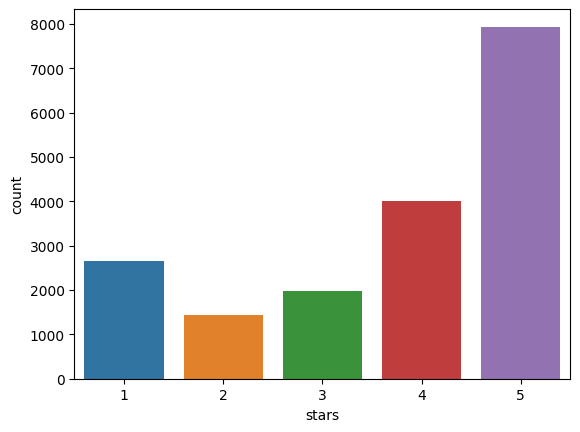

In [6]:
# Observe the distribution of the dataset
import seaborn as sns
sns.countplot(x='stars', data=train_df)

In [14]:
dataset_info = {"1":0, "2":0, "3":0, "4":0, "5":0}
for rating in train_df["stars"]:
    dataset_info[str(rating)] += 1
print(f"Dataset distribution: {dataset_info}")

for rating in dataset_info:
    dataset_info[rating] /= len(train_df["stars"])
    dataset_info[rating] = round(dataset_info[rating], 2)
print(f"Dataset distribution(%): {dataset_info}")

# Dataset is imbalance: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

Dataset distribution: {'1': 3158, '2': 2426, '3': 2968, '4': 4008, '5': 7937}
Dataset distribution(%): {'1': 0.15, '2': 0.12, '3': 0.14, '4': 0.2, '5': 0.39}


In [15]:
train_df['num_words'] = train_df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
train_df['num_words'].describe()

count    20497.000000
mean       132.068498
std        124.767957
min          2.000000
25%         52.000000
50%         92.000000
75%        169.000000
max       1136.000000
Name: num_words, dtype: float64

In [ ]:
"""q1 = np.quantile(train_df["num_words"], 0.25)
q3 = np.quantile(train_df["num_words"], 0.75)
med = np.median(train_df["num_words"])

iqr = q3-q1

upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
outliers = train_df["num_words"][(train_df["num_words"] <= lower_bound) | (train_df["num_words"] >= upper_bound)]

train_df.drop(train_df["num_words"][(train_df["num_words"] <= lower_bound) | (train_df["num_words"] >= upper_bound)].index, axis=0, inplace=True)
train_df = train_df.reset_index()
print(train_df.shape)"""

### Text Preprocessing

In [82]:
lemmatizer = WordNetLemmatizer()
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',  "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such','own', 'same', 's', 't', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'ma', 'shan']

In [83]:
def preprocess_text(text):
  # 1. remove special character (e.g. \n (new line character), \d)
  no_spec_char = re.sub(r"(\s?\\\w)", " ", text)

  # 2. remove number (e.g. 1, 145, 34... etc)
  no_num = re.sub(r"\d+", " ", no_spec_char)
  no_num = re.sub(r"was", " ", no_num)

  # 3. remove punctuation
  # string.punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
  no_punc = [char for char in no_num if char not in string.punctuation]
  no_punc = ''.join(no_punc)

  # 4. tokenization
  tokenize = nltk.word_tokenize(no_punc)

  # 5. Lower casing
  lower = [word.lower() for word in tokenize]

  # 6. perform lammatization/stemming
  lem_word = [lemmatizer.lemmatize(word) for word in lower]
 
  # 7. remove stopwords (useless words and data)
  clean_words = [word.lower() for word in lem_word if word.lower() not in stop_words]
  
  return clean_words

In [84]:
train_preprocess_reviews = list()
for review in list(train_df["text"]):
    train_preprocess_reviews.append(preprocess_text(review))
    
train_df["preprocessed_text"] = train_preprocess_reviews 
train_df["num_word_after_preprocessed"] = train_df["preprocessed_text"].apply(lambda x: len(x))
train_df["num_word_after_preprocessed"].describe()

count    17997.000000
mean        64.799022
std         60.030846
min          2.000000
25%         26.000000
50%         46.000000
75%         83.000000
max        563.000000
Name: num_word_after_preprocessed, dtype: float64

In [85]:
train_preprocess_reviews  = np.array(train_preprocess_reviews)
np.save("train_preprocess_review.npy", train_preprocess_reviews)

/tmp/ipykernel_727/3440549977.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_preprocess_reviews  = np.array(train_preprocess_reviews)


In [86]:
valid_preprocess_reviews = list()
for review in list(valid_df["text"]):
    valid_preprocess_reviews.append(preprocess_text(review))
    
valid_df["preprocessed_text"] = valid_preprocess_reviews
valid_df["num_word_after_preprocessed"] = valid_df["preprocessed_text"].apply(lambda x: len(x))
valid_df["num_word_after_preprocessed"].describe()

count    2000.000000
mean       64.967500
std        55.972841
min         4.000000
25%        28.000000
50%        47.000000
75%        83.000000
max       507.000000
Name: num_word_after_preprocessed, dtype: float64

In [87]:
valid_preprocess_reviews = np.array(valid_preprocess_reviews)
np.save("valid_preprocess_reviews.npy", valid_preprocess_reviews)

/tmp/ipykernel_727/409614685.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  valid_preprocess_reviews = np.array(valid_preprocess_reviews)


### Word embedding

In [52]:
import gensim.downloader as api
glove = api.load('glove-wiki-gigaword-300')

In [ ]:
# Word embedding GloVe: https://www.youtube.com/watch?v=Fn_U2OG1uqI&ab_channel=NormalizedNerd
# https://www.youtube.com/watch?v=InCWrgrUJT8&ab_channel=Scarlett%27sLog  

Model

In [88]:
class ReviewDataset(tf.keras.utils.Sequence):

    def __init__(self, X_set, y_set, batch_size, set_type):
        super(ReviewDataset, self).__init__()
        self.X = X_set
        self.y = y_set
        self.batch_size = batch_size
        self.type = set_type
        self.maxlen = 120
    
    def GloVE(self, batch):
        vec_reviews = list()
        percentage = 0
        for i, review in enumerate(batch):
            vec_review = list()
            pad = np.zeros((self.maxlen, 300)).tolist()
            #banchmark = int(len(review)*percentage)
            for j, word in enumerate(review):
                try:
                    wordvec = glove[word].tolist()
                    vec_review.append(wordvec)
                except:
                    #print(f"[{word}] in review {i} cannot be converted to vector and thus removed")
                    pass
            """if (len(vec_review) <= banchmark):
                removed_data.append(i)
                print(review)
                continue"""
            if (len(vec_review) >= self.maxlen):
                pad = vec_review[:self.maxlen]
            else:
                pad[:len(vec_review)] = vec_review
            vec_reviews.append(pad)
        return vec_reviews

    def __len__(self):
        return math.ceil(len(self.X)/self.batch_size)
    
    def __getitem__(self, idx):
        low = idx*self.batch_size
        high = min(low+self.batch_size, len(self.X))
        batch_x = self.X[low:high]
        batch_y = self.y[low:high]
        batch_x = np.array(self.GloVE(batch_x))
        batch_y = np.array(batch_y)
        batch_x = tf.convert_to_tensor(batch_x)
        batch_y = tf.convert_to_tensor(batch_y)
        return batch_x, batch_y



In [89]:
train_preprocess_reviews = np.load("train_preprocess_review.npy", allow_pickle=True)
valid_preprocess_reviews = np.load("valid_preprocess_reviews.npy", allow_pickle=True)

In [90]:
train_labels = list(train_df["stars"])
train_one_hot_labels = list()
for label in train_labels:
    one_hot = np.eye(5)[label-1]
    train_one_hot_labels.append(one_hot)

In [91]:
valid_labels = list(valid_df["stars"])
valid_one_hot_labels = list()
for label in valid_labels:
    one_hot = np.eye(5)[label-1]
    valid_one_hot_labels.append(one_hot)

In [92]:
print(len(train_preprocess_reviews))
print(len(train_one_hot_labels))

17997
17997


In [154]:
train_set = ReviewDataset(train_preprocess_reviews, train_one_hot_labels, 64, "train")
valid_set = ReviewDataset(valid_preprocess_reviews, valid_one_hot_labels, 64, "valid")

In [119]:
checkpoint_filepath = './checkpoint3'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks = [model_checkpoint_callback]

In [155]:
model = Sequential()
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(tf.keras.layers.Flatten())
"""model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))"""
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation=tf.nn.softmax))

In [156]:
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.01, decay=1e-3)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

In [157]:
history_lstm = model.fit(train_set, epochs=10, validation_data=valid_set, callbacks=callbacks)

Epoch 1/10
282/282 [==============================] - ETA: 0s - loss: 1.3203 - acc: 0.4849
Epoch 1: val_acc did not improve from 0.54750
282/282 [==============================] - 69s 244ms/step - loss: 1.3203 - acc: 0.4849 - val_loss: 1.0962 - val_acc: 0.5475
Epoch 2/10
282/282 [==============================] - ETA: 0s - loss: 0.9634 - acc: 0.6077
Epoch 2: val_acc improved from 0.54750 to 0.56150, saving model to ./checkpoint3
282/282 [==============================] - 68s 241ms/step - loss: 0.9634 - acc: 0.6077 - val_loss: 1.0468 - val_acc: 0.5615
Epoch 3/10
282/282 [==============================] - ETA: 0s - loss: 0.7253 - acc: 0.7119
Epoch 3: val_acc did not improve from 0.56150
282/282 [==============================] - 68s 240ms/step - loss: 0.7253 - acc: 0.7119 - val_loss: 1.1882 - val_acc: 0.5595
Epoch 4/10
282/282 [==============================] - ETA: 0s - loss: 0.5360 - acc: 0.7947
Epoch 4: val_acc did not improve from 0.56150
282/282 [==============================] - 67

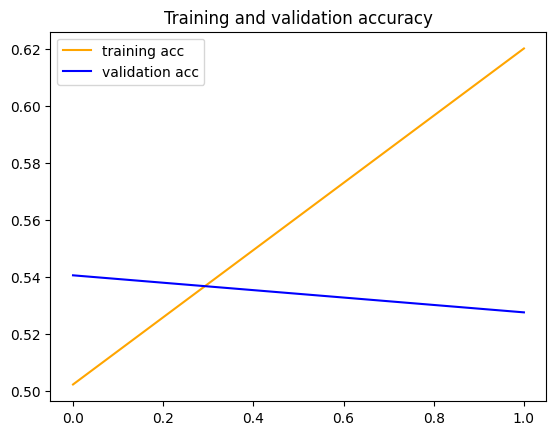

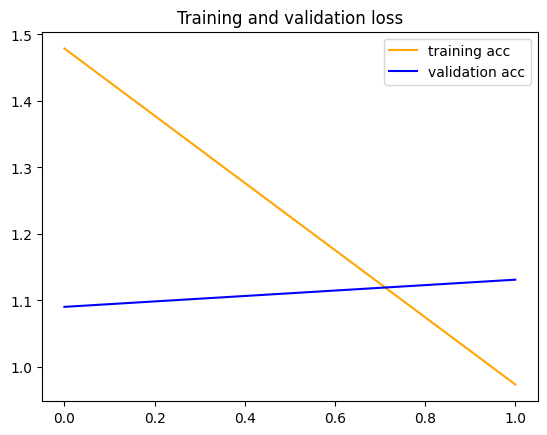

In [135]:
acc = history_lstm.history['acc']
val_acc = history_lstm.history['val_acc']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [141]:
model.load_weights(checkpoint_filepath)

In [158]:
outputs = model.predict(valid_set)

32/32 [==============================] - 7s 232ms/step


In [159]:
valid_predict_labels = np.argmax(outputs, axis=1).tolist()

In [160]:
for i in range(len(valid_predict_labels)):
    valid_predict_labels[i] += 1

In [161]:
print(valid_predict_labels)
print(valid_labels)

[4, 4, 1, 5, 1, 4, 5, 3, 5, 3, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 4, 5, 4, 4, 5, 5, 4, 1, 5, 5, 5, 5, 2, 5, 4, 4, 4, 1, 4, 4, 5, 1, 2, 3, 5, 5, 1, 4, 4, 1, 4, 1, 1, 5, 4, 5, 1, 5, 4, 1, 3, 5, 3, 5, 5, 5, 4, 1, 4, 1, 5, 4, 4, 2, 5, 5, 5, 1, 5, 2, 1, 2, 4, 5, 1, 5, 5, 5, 2, 5, 5, 5, 1, 5, 5, 4, 5, 1, 2, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 5, 5, 5, 1, 5, 1, 5, 4, 5, 1, 5, 5, 4, 5, 5, 2, 1, 5, 5, 2, 2, 1, 5, 4, 1, 4, 1, 5, 5, 4, 5, 5, 1, 2, 5, 3, 5, 5, 4, 2, 2, 3, 5, 5, 3, 1, 1, 4, 5, 4, 5, 5, 5, 5, 4, 4, 5, 4, 4, 3, 2, 1, 4, 5, 5, 5, 4, 5, 5, 5, 1, 4, 1, 1, 4, 5, 5, 4, 5, 1, 2, 4, 1, 1, 2, 5, 5, 1, 3, 3, 1, 1, 5, 5, 4, 4, 5, 5, 5, 5, 1, 5, 5, 4, 1, 5, 3, 5, 5, 1, 4, 5, 5, 5, 4, 4, 4, 5, 4, 4, 2, 1, 5, 4, 4, 5, 5, 4, 5, 3, 5, 5, 5, 2, 1, 4, 1, 1, 4, 5, 5, 1, 5, 3, 3, 1, 3, 1, 5, 2, 5, 4, 5, 3, 5, 4, 5, 4, 1, 4, 4, 5, 4, 4, 1, 1, 4, 5, 4, 4, 5, 5, 5, 5, 5, 4, 5, 5, 1, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 1, 1, 3, 5, 5, 5, 4, 5, 5, 5, 5, 5, 3, 1, 1, 5, 5, 4, 

In [162]:
correct = 0
for i, label in enumerate(valid_predict_labels):
    if (label == valid_labels[i]):
        correct += 1
print(correct)


1091


In [163]:
# checkpoint accuracy: 0.6428
# checkpoint2 accuracy: 0.63350
# checkpoint3 accuracy: 0.6420 (best) (get it after 5 epochs)
from sklearn.metrics import classification_report
print(classification_report(valid_labels, valid_predict_labels, digits=4))

              precision    recall  f1-score   support

           1     0.5850    0.6952    0.6354       292
           2     0.2481    0.1963    0.2192       163
           3     0.2977    0.1681    0.2149       232
           4     0.3365    0.3349    0.3357       421
           5     0.6940    0.7578    0.7245       892

    accuracy                         0.5455      2000
   macro avg     0.4323    0.4305    0.4259      2000
weighted avg     0.5205    0.5455    0.5294      2000



In [72]:
test_reviews = pd.read_csv("./data/test.csv")
test_reviews.head()

,business_id,cool,date,funny,review_id,text,useful,user_id
0,V-qDa2kr5qWdhs7PU-l-3Q,0,2013-05-29,0,fBHWLNEJmhk6AkzmfLwWcw,Would like to give this more stars - usually I...,1,1pigoFijaHVWGrQl1_tYjw
1,C1zlvNlxlGZB8g0162QslQ,0,2012-03-02 15:51:49,0,ldEQ02aP1OeSa5N2beseNg,My wife and I took some friends here after din...,0,BKWPuPZFcGmgjRFRzoq1pw
2,0FOON_PNvG0ZxIZh6Jcv2A,0,2013-09-24 20:31:37,0,0oGr6v9VjtRsRsROGMoWTA,My husband and I had lunch here for the first ...,0,BYVYXKqNs-vv-N1ZhRMs0g
3,r49iBfbnfoK7yt4rdsL_7g,0,2018-10-20 01:34:08,0,eg5eJ5HmqXuzkxucnKvMTw,I love coming here with my friends! Great for ...,2,dpzmyNglDMeTgV3T5ylUSQ
4,xnLNPkL7bbdhD842T4oPqg,0,2016-09-25,1,BNDAe34Mxj--Brkzcfi4QA,Make sure that you double check how much these...,1,yk9wx31bfMEe_IXB8Q-ylA


In [70]:
test_preprocess_reviews = list()
for review in list(test_reviews["text"]):
    test_preprocess_reviews.append(preprocess_text(review))